In [13]:
import time
import random

with open('updated_ocean.csv', 'r') as file:
    lines = file.readlines()

x_data = []
y_data = []

for line in lines[1:]:
    parts = line.strip().split(',')
    if len(parts) < 10:
        continue
    try:
        longitude = float(parts[0])
        latitude = float(parts[1])
        age = float(parts[2])
        total_rooms = float(parts[3])
        total_bedrooms = float(parts[4])
        population = float(parts[5])
        households = float(parts[6])
        income = min(float(parts[7]), 15)
        value = float(parts[8])
        ocean_proximity = float(parts[9])

        if total_rooms == 0 or households == 0:
            continue

        rooms_per_person = total_rooms / population if population != 0 else 0
        bedrooms_per_room = total_bedrooms / total_rooms
        income_per_household = income / households
        rooms_per_household = total_rooms / households
        population_per_household = population / households

        features = [
            longitude,
            latitude,
            age,
            income,
            rooms_per_person,
            bedrooms_per_room,
            rooms_per_household,
            population_per_household,
            income_per_household,
            ocean_proximity
        ]

        x_data.append(features)
        y_data.append(value)
    except:
        continue

sorted_y = sorted(y_data)
clip_value = sorted_y[int(len(sorted_y) * 0.99)]
y_data = [min(v, clip_value) for v in y_data]

num_features = len(x_data[0])
x_mean = [0] * num_features
x_std = [0] * num_features

for j in range(num_features):
    col = [x[j] for x in x_data]
    mean = sum(col) / len(col)
    std = (sum((v - mean) ** 2 for v in col) / len(col)) ** 0.5
    x_mean[j] = mean
    x_std[j] = std

for i in range(len(x_data)):
    for j in range(num_features):
        if x_std[j] != 0:
            x_data[i][j] = (x_data[i][j] - x_mean[j]) / x_std[j]
        else:
            x_data[i][j] = 0

for i in range(len(x_data)):
    x_data[i] = [1.0] + x_data[i]

y_min = min(y_data)
y_max = max(y_data)
y_data = [(y - y_min) / (y_max - y_min) for y in y_data]

split = int(0.8 * len(x_data))
x_train = x_data[:split]
y_train = y_data[:split]
x_test = x_data[split:]
y_test = y_data[split:]

weights = [random.uniform(-0.01, 0.01) for _ in range(len(x_train[0]))]
alpha = 0.01
epochs = 10000
lambda_reg = 0.1
n = len(x_train)

costs = []

start_time = time.time()
for epoch in range(epochs):
    gradients = [0] * len(weights)
    cost_sum = 0
    for i in range(n):
        pred = sum(x_train[i][j] * weights[j] for j in range(len(weights)))
        error = pred - y_train[i]
        cost_sum += error**2
        for j in range(len(weights)):
            gradients[j] += error * x_train[i][j]
    cost = (cost_sum / (2*n)) + (lambda_reg / 2) * sum(w**2 for w in weights[1:])
    costs.append(cost)c
    for j in range(len(weights)):
        gradients[j] /= n
        gradients[j] += lambda_reg * weights[j]
    gradients[0] -= lambda_reg * weights[0]
    for j in range(len(weights)):
        weights[j] -= alpha * gradients[j]
end_time = time.time()

print("Training time:", end_time - start_time, "seconds")

Training time: 445.39804005622864 seconds


In [17]:
def evaluate(x, y_true, weights):
    n = len(x)
    preds = [sum(x[i][j] * weights[j] for j in range(len(weights))) for i in range(n)]
    errors = [y_true[i] - preds[i] for i in range(n)]
    mae = sum(abs(e) for e in errors) / n
    rmse = (sum(e**2 for e in errors) / n) ** 0.5
    y_mean = sum(y_true) / n
    total_var = sum((y - y_mean) ** 2 for y in y_true)
    residual_var = sum(e ** 2 for e in errors)
    r2 = 1 - residual_var / total_var if total_var != 0 else 0
    return mae, rmse, r2

mae, rmse, r2 = evaluate(x_test, y_test, weights)

custom_input = [
    -122.23,
    37.88,
    41,
    8.3252,
    880 / 322,
    129 / 880,
    880 / 126,
    322 / 126,
    8.3252 / 126,
    259212
]

for j in range(len(custom_input)):
    if x_std[j] != 0:
        custom_input[j] = (custom_input[j] - x_mean[j]) / x_std[j]
    else:
        custom_input[j] = 0

custom_input = [1.0] + custom_input
predicted_normalized = sum(custom_input[j] * weights[j] for j in range(len(weights)))
predicted_normalized = max(0, min(1, predicted_normalized))
predicted_value = predicted_normalized * (y_max - y_min) + y_min

print("Predicted median_house_value:", predicted_value)
print("MAE:", mae * (y_max - y_min))
print("RMSE:", rmse * (y_max - y_min))
print("R² Score:", r2)
print("Trained weights:", weights)

Predicted median_house_value: 400959.50321178185
MAE: 48515.65266438649
RMSE: 68558.20129953143
R² Score: 0.6774388744924902
Trained weights: [0.38914547046333625, -0.026693954894032212, -0.033449754460879076, 0.022904989866255804, 0.14496130560715376, 0.05915814108767789, 0.01791219437597423, -0.039390362307830676, -0.007771095279885952, -0.002602948148881912, 0.054924651985118415]


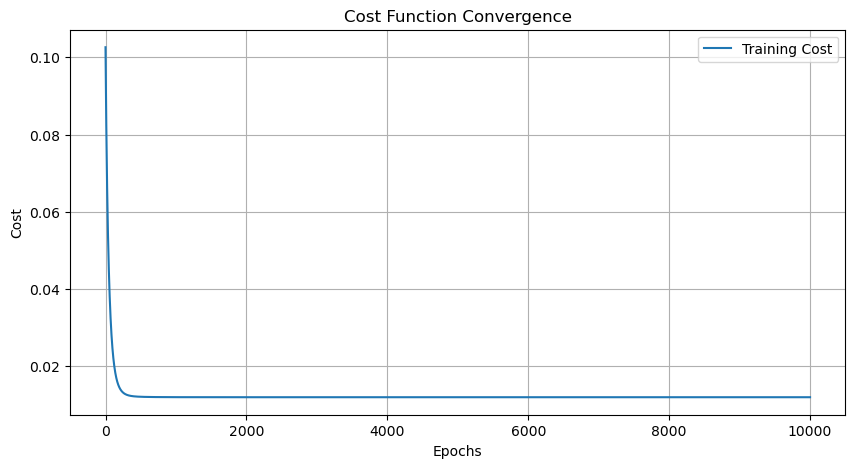

In [18]:
# Plot cost function convergence
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(len(costs)), costs, label='Training Cost')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Cost Function Convergence')
plt.grid(True)
plt.legend()
plt.show()

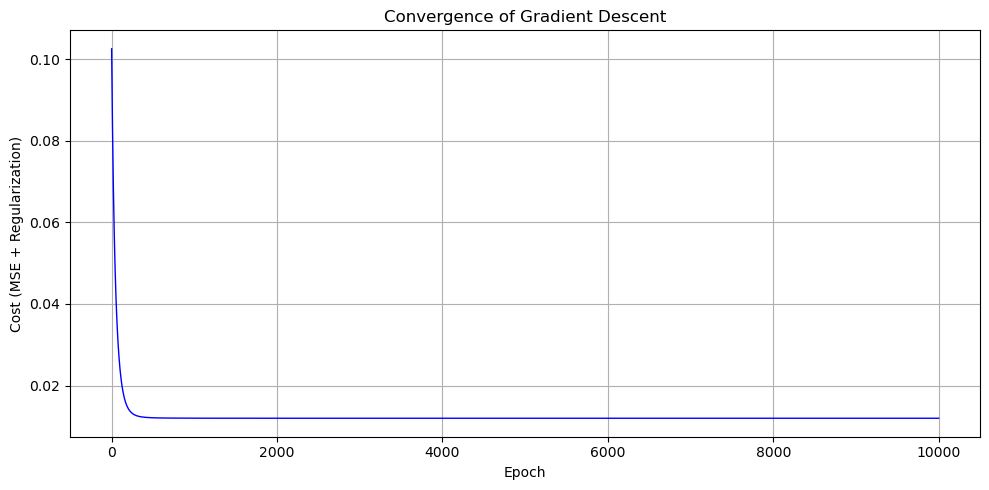

In [19]:
import matplotlib.pyplot as plt

# Plot cost vs. epochs
plt.figure(figsize=(10, 5))
plt.plot(range(len(costs)), costs, color='blue', linewidth=1)
plt.title("Convergence of Gradient Descent")
plt.xlabel("Epoch")
plt.ylabel("Cost (MSE + Regularization)")
plt.grid(True)
plt.tight_layout()
plt.show()